In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

In [4]:
import cv2
from numpy import genfromtxt
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
import h5py
import matplotlib.pyplot as plt
import os.path

Model Loading

In [5]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis = -1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis = -1)
    basic_loss = pos_dist- neg_dist + alpha
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0.0))
    
    return loss

In [10]:
FrNet = tf.keras.models.load_model('/content/drive/MyDrive/FrNet', custom_objects={'triplet_loss': triplet_loss})

In [17]:
EmoNet = tf.keras.models.load_model('/content/drive/MyDrive/emonet2.h5')

Extracting Faces

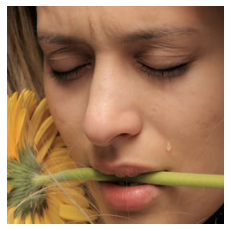

In [12]:
import dlib
from PIL import Image
from skimage import io
import matplotlib.pyplot as plt


def detect_faces(image):

    # Create a face detector
    face_detector = dlib.get_frontal_face_detector()

    # Run detector and get bounding boxes of the faces on image.
    detected_faces = face_detector(image, 1)
    face_frames = [(x.left(), x.top(),
                    x.right(), x.bottom()) for x in detected_faces]

    return face_frames

# Load image
img_path = '/content/drive/MyDrive/sadwaman.jpg'
image = io.imread(img_path)

# Detect face
detected_faces = detect_faces(image)

# Crop faces and plot
for n, face_rect in enumerate(detected_faces):
    face = Image.fromarray(image).crop(face_rect)
    plt.subplot(1, len(detected_faces), n+1)
    plt.axis('off')
    plt.imshow(face)
    filename = "file%d.png" % (n + 1)
    plt.savefig(filename)

Working on Image

In [28]:
def img_to_encoding(image_path, model):
    img1 = cv2.imread(image_path, 1)
    img = img1[...,::-1]
    img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
    x_train = np.array([img])
    embedding = model.predict_on_batch(x_train)
    return embedding

In [14]:
def predict_score(img_path, show=False):

    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(48, 48))
    img_tensor = tf.keras.preprocessing.image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    model_class = np.argmax(EmoNet.predict(img_tensor), axis=-1)
    if model_class == 0:
      return 3
    elif model_class == 1:
      return 2
    else:
      return 1


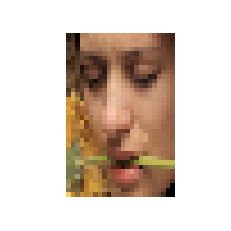

1

In [18]:
predict_score('/content/file1.png', show=True)

In [19]:
database = {}
database["danielle"] = img_to_encoding("/content/drive/MyDrive/images/danielle.png", FrNet)
database["younes"] = img_to_encoding("/content/drive/MyDrive/images/younes.jpg", FrNet)
database["tian"] = img_to_encoding("/content/drive/MyDrive/images/tian.jpg", FrNet)
database["andrew"] = img_to_encoding("/content/drive/MyDrive/images/andrew.jpg", FrNet)
database["kian"] = img_to_encoding("/content/drive/MyDrive/images/kian.jpg", FrNet)
database["dan"] = img_to_encoding("/content/drive/MyDrive/images/dan.jpg", FrNet)
database["sebastiano"] = img_to_encoding("/content/drive/MyDrive/images/sebastiano.jpg",FrNet)
database["bertrand"] = img_to_encoding("/content/drive/MyDrive/images/bertrand.jpg", FrNet)
database["kevin"] = img_to_encoding("/content/drive/MyDrive/images/kevin.jpg", FrNet)
database["felix"] = img_to_encoding("/content/drive/MyDrive/images/felix.jpg", FrNet)
database["benoit"] = img_to_encoding("/content/drive/MyDrive/images/benoit.jpg", FrNet)
database["arnaud"] = img_to_encoding("/content/drive/MyDrive/images/arnaud.jpg", FrNet)

In [21]:
def identify(image_path, database, model):

    encoding = img_to_encoding(image_path, model)

    min_dist = 100

    for (name, db_enc) in database.items():

        dist = np.linalg.norm(encoding-db_enc)

        if dist < min_dist:
            min_dist = dist
            identity = name
   
    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    return min_dist, identity

In [31]:
identify("/content/drive/MyDrive/images/arnaud.jpg", database, FrNet)

it's arnaud, the distance is 0.0


(0.0, 'arnaud')

Working with csv